<a href="https://colab.research.google.com/github/CherpanovNazim/learn-llm/blob/main/notebooks/04_Retrieval_augmented_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


> [GitHub Repo](https://github.com/CherpanovNazim/learn-llm)

# Setup

In [ ]:
#clone git repository
!git clone -q https://github.com/CherpanovNazim/learn-llm.git

In [ ]:
!pip install -qU \
    transformers==4.44.0 \
    sentence-transformers==3.0.1 \
    pinecone-client==4.1.2 \
    datasets==2.20.0 \
    accelerate==0.32.1 \
    einops==0.8.0 \
    langchain==0.2.13 \
    docarray==0.40.0 \
    rank_bm25==0.2.2 \
    langchain-huggingface==0.0.3 \
    langchain-openai==0.1.17 \
    fsspec==2024.5.0 \
    langchain-community==0.2.12 \
    openai==1.40.3 \
    vllm==0.5.4


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.7/360.7 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.2/797.2 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 95.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.8/20.8 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.9/101.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/

# RAG (Retrieval Augmented Generation) System

**Retrieval Augmented Generation (RAG)** is a natural language processing (NLP) technique that combines the strengths of large language models (LLMs) and information retrieval (IR) systems to improve the quality of generated text.

LLMs are trained on massive datasets of text and code, and can generate text, translate languages, write different kinds of creative content, and answer your questions in an informative way. However, LLMs can be inaccurate and inconsistent, especially when asked questions about specific facts or topics.

IR systems are designed to find relevant documents in a large corpus of text. RAG systems leverage the strengths of both LLMs and IR systems to generate more accurate, informative, and diverse text.

**How RAG works**

RAG systems work in two stages:

1. **Retrieval:** The RAG system first uses an IR system to retrieve a set of relevant documents from an external knowledge base, such as Wikipedia or company-specific internal databases.
2. **Generation:** The RAG system then passes the retrieved documents to an LLM, which generates text based on the documents and the original input prompt.

The LLM can generate text in a variety of formats, including text, code, scripts, musical pieces, email, letters, etc.

**Benefits of RAG systems**

RAG systems offer a number of benefits over traditional LLM-based NLP systems:

* **Accuracy:** RAG systems are more accurate than traditional LLM-based NLP systems because they are grounded in real-world knowledge from external knowledge bases.
* **Informativeness:** RAG systems can generate more informative text than traditional LLM-based NLP systems because they have access to a wider range of information.
* **Diversity:** RAG systems can generate more diverse text than traditional LLM-based NLP systems because they are not limited by the biases of their training data.

**Applications of RAG systems**

RAG systems can be used for a variety of NLP tasks, including:

* Question answering
* Text summarization
* Creative text generation
* Code generation

**Here are some examples of how RAG systems can be used:**

* A customer service chatbot can use RAG to retrieve relevant knowledge base articles to answer customer questions more accurately and informatively.
* A news article summarization system can use RAG to retrieve relevant news articles and generate summaries that are more comprehensive and informative.
* A code generation system can use RAG to retrieve relevant code snippets and generate code that is more efficient and bug-free.

Overall, RAG systems are a powerful new tool for improving the quality and relevance of generated text.

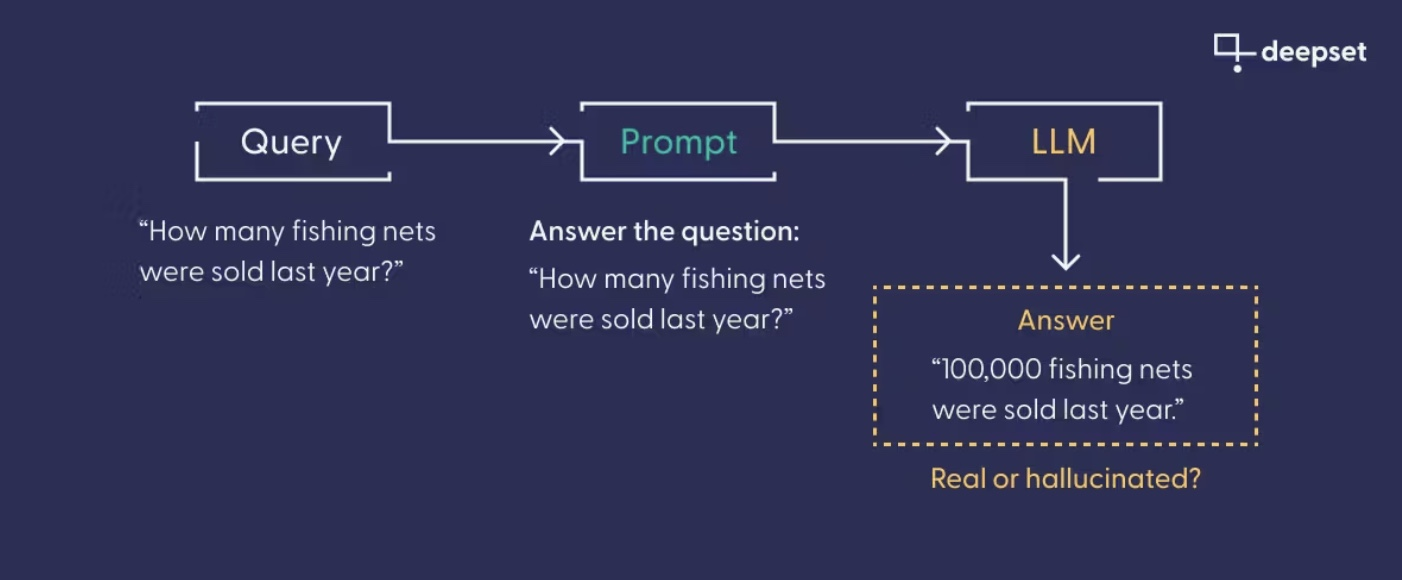

Image source: https://www.deepset.ai/blog/llms-retrieval-augmentation

# Basic Example

## Text Embedding

For text embedding we'll be using all-MiniLM-L6-v2 model from the HuggingFace that embeds texts into 384 dimensional vectors.

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings

embed_model_id = 'sentence-transformers/all-MiniLM-L6-v2'

embed_model = HuggingFaceEmbeddings(
    model_name=embed_model_id
)

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Testing embedding model
docs = [
    "first document",
    "second document"
]
embeddings = embed_model.embed_documents(docs)
print(f"There are {len(embeddings)} document embeddings, each with " f"a dimensionality of {len(embeddings[0])}.")

There are 2 document embeddings, each with a dimensionality of 384.


## Load Dataset

Dataset consists of contains chunked extracts (of ~300 tokens) from papers related to (and including) the Llama 2 research paper. More information is available at: https://huggingface.co/datasets/jamescalam/llama-2-arxiv-papers-chunked

In [ ]:
from datasets import load_dataset

data = load_dataset(
    'jamescalam/llama-2-arxiv-papers-chunked',
    split='train'
)
data

Generating train split:   0%|          | 0/4838 [00:00<?, ? examples/s]

Dataset({
    features: ['doi', 'chunk-id', 'chunk', 'id', 'title', 'summary', 'source', 'authors', 'categories', 'comment', 'journal_ref', 'primary_category', 'published', 'updated', 'references'],
    num_rows: 4838
})

In [ ]:
import pandas as pd
# Save dataset into pandas dataframe
data = data.to_pandas()

# Inspect
data.columns

# Dropping duplicate chunks
data = data.drop_duplicates(subset=['chunk'])
data.shape

(3547, 15)

## Create Local Vector Database

We need Document type data structure that stores not only text that our model will work on but metadata as well

In [ ]:
from langchain.schema.document import Document

def example_to_document(example: dict) -> Document:
    return Document(
        page_content=str(example["chunk"]),
        metadata={
            "chunk-id": str(example["chunk-id"]),
            "id": str(example['id']),
            "title": str(example["title"]),
            "summary": str(example["summary"]),
        },
    )

For storing embeddings and associate metadata we'll be using DocArrayInMemorySearch based on Docarray module that creates in memory database. It's usefull for demonstration purposes and small datasets. For large datasets specialized vector DBs are recommended with built-in specialized algorithms for fast and efficient search and retrieval.

In [ ]:
# Converting each text chunk to Document type structure
docs = [example_to_document(example) for example in data[['chunk', 'chunk-id','id', 'title', 'summary']].to_dict(orient='records')]

In [ ]:
from langchain.vectorstores import DocArrayInMemorySearch

# Create database of embeddings
db = DocArrayInMemorySearch.from_documents(docs, embed_model)

/usr/local/lib/python3.10/dist-packages/pydantic/_migration.py:283: UserWarning: `pydantic.error_wrappers:ValidationError` has been moved to `pydantic:ValidationError`.
  warnings.warn(f'`{import_path}` has been moved to `{new_location}`.')


## Retriever Component

A retriever in a RAG system is an algorithm that searches a large corpus of text and retrieves the most relevant passages for a given query.

It is essential for providing the LLM generator with the necessary context to generate a high-quality response. Without the retriever, the generator would have to rely solely on its own internal knowledge, which would limit its ability to generate accurate and informative responses.

In [ ]:
# Let's test the LLAMA model with a query that could be confused with an animal
query = "what is so special about llama 2?"

In [ ]:
# search for the top 5 contextually most similar chunks of texts
res = db.similarity_search_with_score(query, k = 5)
res

[(Document(metadata={'chunk-id': '199', 'id': '2307.09288', 'title': 'Llama 2: Open Foundation and Fine-Tuned Chat Models', 'summary': 'In this work, we develop and release Llama 2, a collection of pretrained and\nfine-tuned large language models (LLMs) ranging in scale from 7 billion to 70\nbillion parameters. Our fine-tuned LLMs, called Llama 2-Chat, are optimized for\ndialogue use cases. Our models outperform open-source chat models on most\nbenchmarks we tested, and based on our human evaluations for helpfulness and\nsafety, may be a suitable substitute for closed-source models. We provide a\ndetailed description of our approach to fine-tuning and safety improvements of\nLlama 2-Chat in order to enable the community to build on our work and\ncontribute to the responsible development of LLMs.'}, page_content='Ricardo Lopez-Barquilla, Marc Shedroﬀ, Kelly Michelena, Allie Feinstein, Amit Sangani, Geeta\nChauhan,ChesterHu,CharltonGholson,AnjaKomlenovic,EissaJamil,BrandonSpence,Azadeh\n

## Testing LLama 3 Model without RAG

Now test the model for the defined query without providing any context.

In [ ]:
# wait ~3 min for installations
%%time

import json
import sys

# Load the default model
DEFAULT_MODEL = json.load(open('learn-llm/configs/llama_3_8B_instruct_awq.json', 'r'))

# #run VLLM
!nohup vllm serve {DEFAULT_MODEL['model']} --chat-template learn-llm/configs/chat_template.jinja --quantization awq --max-model-len=4096 > vllm.log &
!tail -f vllm.log | grep -q "Uvicorn running" && echo "Now you can start using the model"

nohup: redirecting stderr to stdout
Now you can start using the model
CPU times: user 795 ms, sys: 125 ms, total: 920 ms
Wall time: 2min 13s


In [ ]:
# Initialize LLM
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model = DEFAULT_MODEL["model"], openai_api_base=DEFAULT_MODEL['api_base'], openai_api_key=DEFAULT_MODEL['api_key'])

In [ ]:
llm_output = llm.invoke(query)
print(llm_output.content)

I'm not aware of any specific information about "Llama 2" being special. However, I can provide some context. 

Llama 2 is a mode of the AI model developed by Meta. It is an improved version of the previous Llama model, which stands for 'Large Language Model Meta AI'. 

The Llama 2 model boasts several upgrades and improvements over its predecessor, including:

1. **Significant size increase**: Llama 2 is a much larger model than its predecessor, with 65,000 million parameters. This increase in size allows the model to absorb and process vast amounts of information, enabling it to generate more accurate and nuanced responses.

2. **Improved generation quality**: Llama 2 has been fine-tuned to produce higher-quality text, with a greater ability to recognize and replicate human-like writing styles. The model's capacity for creative writing, storytelling, and even humor has been significantly enhanced.

3. **Greater attention span**: Llama 2 can process longer strings of text and maintain

## Testing LLAMA 3 Model with RAG

In the wider scope of the LLAMA 3 model, word-number combination of llama+2 most likely refers to the animal. Let's try the same query
with RAG pipeline to shrink the context space.

In [ ]:
from langchain.chains import RetrievalQA

# Define retriever
retriever = db.as_retriever(search_type='similarity', search_kwargs={'k': 5})
# Define RAG chain
qa_chain = RetrievalQA.from_chain_type(llm,retriever=retriever, chain_type='stuff')
response=qa_chain.invoke({"query": query})
rag_output = response['result']

# Pretty-print the output
rag_lines = rag_output.split('\n')
for line in rag_lines:
    print(line)

Llama 2 is a collection of large language models (LLMs) developed and released by Meta. What's special about Llama 2 is that it's a family of models ranging in scale from 7 billion to 70 billion parameters, making it one of the largest and most advanced language models available.

Here are some key features that make Llama 2 stand out:

1. **Large scale**: Llama 2 models have a massive number of parameters, allowing them to capture complex patterns and relationships in language.
2. **Pretraining and fine-tuning**: Llama 2 models are pre-trained on a large corpus of text data and then fine-tuned for specific use cases, such as dialogue.
3. **Dialogue capabilities**: Llama 2 models are optimized for dialogue use cases, enabling them to engage in conversations and respond to user inputs in a more natural and human-like way.
4. **Human evaluations**: Llama 2 models have been evaluated by humans for helpfulness and safety, and they appear to perform better than existing open-source models a

# More Advanced Example

Previously, the text that we used for our first RAG application, was already chunked/splitted in approximately 300 tokens-sized pieces, however in real-life scenarios, text is given in a raw, unprocessed format and the chunking stage is one of the crucial steps in developing effective RAG application.


In RAG applications, the retriever module is responsible for finding relevant passages from a large corpus of text to provide context for the generative language model (LLM). The LLM then uses this context to generate text, translate languages, or answer questions in a comprehensive and informative way.

Therefore the text chunking is important for RAG applications for several reasons:

* **Efficiency:** Chunking the input text allows the retriever to more efficiently identify relevant passages.
* **Accuracy:** Chunking can also improve the accuracy of the retriever by allowing it to focus on smaller, more coherent, specific units of text.
* **Control:** Chunking gives the developer more control over the retrieval process. For example, the developer can specify the maximum chunk size or the type of chunks to be retrieved (e.g., sentences, paragraphs, etc.).
* **Context Limitation:** LLM models usualy have finite context window, therefore it's necessary to provide only essential, contextually relevant information to fit into this limitation.


There are a number of different methods for text chunking. Some common methods include:

* **Sentence boundary detection:** This method splits the text into sentences based on punctuation and other syntactic cues.
* **Paragraph boundary detection:** This method splits the text into paragraphs based on indentation, blank lines, and other formatting cues.
* **Topic segmentation:** This method splits the text into segments that are topically coherent. This can be done using a variety of techniques, such as latent Dirichlet allocation (LDA) or topic modeling.


The best chunking method for a particular RAG application will depend on the specific needs of the application. For example, if the goal is to improve the efficiency of the retriever, then a simple sentence or paragraph boundary detection method may be sufficient. However, if the goal is to improve the accuracy of the retriever or to provide more control over the retrieval process, then a more sophisticated topic or discourse segmentation method may be necessary.

## Loading LLama-2 Related Papers
Dataset is available at: https://huggingface.co/datasets/jamescalam/llama-2-arxiv-papers

In [ ]:
data_raw = load_dataset(
    'jamescalam/llama-2-arxiv-papers',
    split='train'
)
data_raw

Generating train split:   0%|          | 0/49 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'title', 'summary', 'source', 'authors', 'categories', 'comment', 'journal_ref', 'primary_category', 'published', 'updated', 'content', 'references'],
    num_rows: 49
})

In [ ]:
# Convert dataset into pandas dataframe
data_raw = data_raw.to_pandas()

# Inspect
data_raw.shape, data_raw.columns

((49, 13),
 Index(['id', 'title', 'summary', 'source', 'authors', 'categories', 'comment',
        'journal_ref', 'primary_category', 'published', 'updated', 'content',
        'references'],
       dtype='object'))

In [ ]:
data_raw.head(2)

,id,title,summary,source,authors,categories,comment,journal_ref,primary_category,published,updated,content,references
0,1102.0183,High-Performance Neural Networks for Visual Ob...,"We present a fast, fully parameterizable GPU i...",http://arxiv.org/pdf/1102.0183,"[Dan C. Cireşan, Ueli Meier, Jonathan Masci, L...","[cs.AI, cs.NE]","12 pages, 2 figures, 5 tables",None,cs.AI,20110201,20110201,High-Performance Neural Networks\nfor Visual O...,[]
1,1301.4083,Knowledge Matters: Importance of Prior Informa...,We explore the effect of introducing prior inf...,http://arxiv.org/pdf/1301.4083,"[Çağlar Gülçehre, Yoshua Bengio]","[cs.LG, cs.CV, cs.NE, stat.ML]","37 Pages, 5 figures, 5 tables JMLR Special Top...",None,cs.LG,20130117,20130713,Knowledge Matters: Importance of Prior Informa...,[]


## Text Chunking

For the demonstration purposes we'll be using **RecursiveCharacterTextSplitter** chunking that results in chunks with the same amount of tokens while doesn't require third-party NLP libraries or models.

The **RecursiveCharacterTextSplitter** divides a given text based on a given chunk size using specific characters. By default, it uses **["\n\n", "\n", " ", ""]**. The process starts by attempting to split the text using the first character, **"\n\n"**. If the resulting split remains too big, it proceeds to the next character, **"\n"**, and so on, until the output is smaller than the **predetermined chunk size**.

In [ ]:
# Define text splitter
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Splitting parameters
chunk_size = 512
chunk_overlap = 25

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap
)

# New dataframe generation
def create_chunked_dataframe(df):

    # store intermdiate results
    new_rows = []

    for _, row in df.iterrows():
        paper_id = row['id']
        chunks = text_splitter.create_documents([row['content']]) #it's necessary to put text into list as RecursiveCharacterTextSplitter expects

        for chunk in chunks:
            new_rows.append({'id': paper_id, 'text': chunk})

    # construct new df
    new_df = pd.DataFrame(new_rows)

    return new_df

In [ ]:
# Create chunks
chunk_df = create_chunked_dataframe(data_raw)

# Dropping duplicate chunks
chunk_df = chunk_df.drop_duplicates(subset=['text'])
chunk_df.shape

(6466, 2)

In [ ]:
chunk_df.head()

,id,text
0,1102.0183,page_content='High-Performance Neural Networks...
1,1102.0183,page_content='and was founded in 1988 by the D...
2,1102.0183,page_content='January 2011\nAbstract\nWe prese...
3,1102.0183,page_content='nets trained by simple back-prop...
4,1102.0183,page_content='and the high in-class variabilit...


## Retrieval

In the basic example **all-MiniLM-L6-v2** model for chunk embeddings that was a crucial step for retrieving chunks contextually most relevant to a given prompt query. For the demonstration purposes, now we'll be using BM25 algorithm that doesn't require any LLM or NLP models and that was developed in early 70s as a probabilistic retrieval algorithm for information search systems.

In [ ]:
from langchain.retrievers import BM25Retriever

# k=10 implies that our RAG system with generate response based on the top 10 most relevant chunks of texts
bm25_retriever = BM25Retriever.from_documents(chunk_df['text'], k=10)

In [ ]:
result = bm25_retriever.invoke(query)
result

[Document(page_content='to understand the format of the task without prior examples, so this setting is in some cases “unfairly hard”.\nFor example, if someone is asked to “make a table of world records for the 200m dash”, this request can be\nambiguous, as it may not be clear exactly what format the table should have or what should be included (and\neven with careful clariﬁcation, understanding precisely what is desired can be difﬁcult). Nevertheless, for at'),
 Document(page_content='to engage critically with what constitutes “bias”\nin the ﬁrst place. Despite the fact that analyzing\n“bias” is an inherently normative process—in\nwhich some system behaviors are deemed good\nand others harmful—papers on “bias” in NLP\nsystems are rife with unstated assumptions about\nwhat kinds of system behaviors are harmful, in\nwhat ways, to whom, and why. Indeed, the term\n“bias” (or “gender bias” or “racial bias”) is used\nto describe a wide range of system behaviors, even'),
 Document(page_conte

## BM25 Based RAG System

As we already have defined LLM model and retriever, we can construct basic RAG system in the same way as before with Langchain.

# THIS DOES NOT PROVIDE CORRECT OUPUT

As seen in old notebook, retriever returns same documents, but RetrievalQA chain does not detect relevant results.
Below is modified chain, that returns correct output using BM25 as a retriever

TODO: decide what chain to keep

In [ ]:
# Define RAG chain
bm25_chain = RetrievalQA.from_chain_type(llm, retriever=bm25_retriever, chain_type='stuff')
bm25_response=bm25_chain({"query": query})
bm25_rag_output = bm25_response['result']

# The output
print(bm25_rag_output)

I don't have any information about a specific "Llama 2" entity. There is a model called LLaMA (Large Language Model Application) developed by Meta, but I'm not aware of a "Llama 2" version.


In [ ]:
from langchain.chains.retrieval import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.prompts import PromptTemplate
from langchain.llms import YourLLMClass  # Replace with the actual LLM class you're using
from langchain.retrievers import YourRetrieverClass  # Replace with the actual retriever class you're using

# Define your prompt directly
retrieval_qa_chat_prompt = PromptTemplate.from_template(
    "Given the following context, answer the question.\n\nContext: {context}\n\nQuestion: {question}\n\nAnswer:"
)

# Create the combine_docs_chain with your LLM and prompt
combine_docs_chain = create_stuff_documents_chain(
    llm=YourLLMClass(),  # Instantiate your LLM here
    prompt=retrieval_qa_chat_prompt
)

# Create the retrieval_chain with your retriever and the combine_docs_chain
retrieval_chain = create_retrieval_chain(
    retriever=YourRetrieverClass(),  # Instantiate your retriever here
    combine_docs_chain=combine_docs_chain
)

# Define your query
query = "What is the capital of France?"

# Invoke the retrieval chain with the query
result = retrieval_chain.invoke({"input": query})
print(result['answer'])

# Homework

BM25 Retriever generated acceptable results after trying different parameters for **RecursiveCharacterTextSplitter** component. There're lot of ways to improve current RAG system, including:
- Changing splitting method (and it parameters);
- Use different embedding model from open-source HuggingFace Model Zoo;
- Use different retrieval method;

Your task is to use:
- Refer to langchain documentation on text splitters and choose try another chunking method:
  https://api.python.langchain.com/en/latest/api_reference.html#module-langchain.text_splitter
(for example, NLTKTextSplitter might result in better context preservation)
- Use different type of retriever method implement in Langchain: https://python.langchain.com/docs/modules/data_connection/retrievers/